Motion Profile Analysis
=======================

TL;DR Combined motions are badly programmed and do not end at the same time. This is not due to a mechanical failure or to weak motors, as evidenced by the results of the unloaded run. Moreover, under load, motor 3 is not powerful enough to meet expectations. Its motions are therefore longer than expected, which results in motor 1 being stalled even longer during combined motions.

Motor 3 is most likely operating on the vertical plane (lifting loads), while motor 1 is either operating in the horizontal plane, or is way more powerful than motor 3.

In [1]:
from datetime import datetime
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

%matplotlib inline

## 1. Log Parsing

As part of our log decoding, we first need a function that converts an array of hex bytes to integers (signed or unsigned) using little endian convention.

In [2]:
def parse_raw(bytes: list[str], signed: bool = True) -> int:
    """Converts array of hex bytes to integer using litte-endian convention."""
    # Convert hex to unsigned int
    val = int("".join(bytes[::-1]), 16)
    if not signed: return val

    # If conversion to signed, adjust result if first bit was one
    if val & (1 << (len(bytes) * 8 - 1)):
        val -= 1 << (len(bytes) * 8)
    return val

Next, we implement a `Message` class that takes a raw log string and parses it into a Python object that is easier to manipulate.

Depending on the communication channel, the resulting `data` array will have different shapes.

In [3]:
class Message:

    def __init__(self, rawMessage: str):
        # Separate timestamp from data
        [timestamp_str, info] = rawMessage.split(")")

        # Parse timestamp
        timestamp_str: str = timestamp_str.strip()[1:]
        self.timestamp: datetime = datetime.strptime(timestamp_str, "%Y-%m-%d %H:%M:%S.%f")
        
        # Split data stream into different parts
        stream: list[str] = info.split()

        # Parse data stream
        self.interface: str = stream[0]
        self.channel: int = int(stream[1]) // 10
        self.drive: int = int(stream[1]) % 10
        self.data_length: int = int(stream[2][1:-1])
        self.raw_bytes: list[str] = stream[3:]

        if len(self.raw_bytes) != self.data_length:
            self.malformed: bool = True
            return

        # Parse raw bytes depending on channel format
        if self.channel == 18:
            self.data: list[int] = [
                parse_raw(self.raw_bytes[0:2], False),
                parse_raw(self.raw_bytes[2:4], True),
                parse_raw(self.raw_bytes[4:8], True)
            ]
        elif self.channel == 28 or self.channel == 38:
            self.data: list[int] = [
                parse_raw(self.raw_bytes[0:4], True),
                parse_raw(self.raw_bytes[4:8], True)
            ]

## 2. Motor Motion Analysis

### 2.1. Unloaded Analysis

We start by loading the logs for the unloaded run.

We parse the information and perform an initial sorting of log messages by node and channel.

In [4]:
def load_logs(path: str) -> tuple[dict[int, dict[int, list[Message]]], dict[int, list[int]]]:
    log_file = open(path, "r")
    
    messages: dict[int, dict[int, list[Message]]] = {}
    nodes: dict[int, list[int]] = {}

    # Parse messages from the log file
    for line in log_file.readlines():
        message = Message(line)

        # Sort the messages by driver and channel
        if message.drive not in messages.keys(): messages[message.drive] = {}
        if message.channel not in messages[message.drive].keys(): messages[message.drive][message.channel] = []
        messages[message.drive][message.channel].append(message)

        # Add driver and channel combination to dictionary if needed
        if message.drive not in nodes.keys(): nodes[message.drive] = []
        if not message.channel in nodes[message.drive]: nodes[message.drive].append(message.channel)
    
    log_file.close()
    
    return messages, nodes

In [5]:
messages_unloaded, nodes_unloaded = load_logs("./logs/unloaded.log")

Now that we have the information parsed. We can look at the generated node dictionary for insight on the information exhanged on the CAN bus.

In [6]:
print("Node | Channels")
print("-----|-----------------------------------------")
for key in sorted(nodes_unloaded.keys()):
    print(f"{key}    | {sorted(nodes_unloaded[key])}")

Node | Channels
-----|-----------------------------------------
0    | [0, 8]
1    | [8, 18, 20, 28, 30, 38, 48, 58, 60, 70]
2    | [18, 28, 38, 58, 60]
3    | [8, 18, 20, 28, 30, 38, 48, 58, 60, 70]
4    | [18, 58, 60]


We know that motor drives will communicate on channels 180, 280, and 380, to broadcast various information about their states.

Thus, we can assume that nodes 1, 2, 3, are motor drives, while nodes 0 and 4 are either inactive or not drives.

#### 2.1.1. Drive 1

Next, we code up a few functions to turn the data for a drive into human-readable graphs.

In [7]:
def plot_pos(ax: plt.Axes, ms: list[Message]):
    """Plots the actual and expected positions on a same graph."""
    ax.plot([m.timestamp for m in ms], [m.data[0] for m in ms], color='g', linestyle="--", label="Position (expected)")
    ax.plot([m.timestamp for m in ms], [m.data[1] for m in ms], color='g', linestyle='-', label="Position (actual)")
    ax.legend()


def plot_spd(ax: plt.Axes, ms: list[Message]):
    """Plots the actual and expected speeds on a same graph."""
    ax.plot([m.timestamp for m in ms], [m.data[0] for m in ms], color='r', linestyle="--", label="Speed (expected)")
    ax.plot([m.timestamp for m in ms], [m.data[1] for m in ms], color='r', linestyle="-", label="Speed (actual)")
    ax.legend()


def plot_trq(ax: plt.Axes, ms: list[Message]):
    """Plots the actual torque and the control effort on a same graph, with two separate y axes."""
    ax.plot([m.timestamp for m in ms], [m.data[1] for m in ms], color='b', label="Torque (Actual)")
    ax2= ax.twinx()
    ax2.plot([m.timestamp for m in ms], [m.data[2] for m in ms], color='c', label="Control Effort")
    ax2.legend(loc='upper right')
    ax.legend(loc='upper left')

    # Center both y axes around 0
    y1_max = max(max([m.data[1] for m in ms]), abs(min([m.data[1] for m in ms])))
    ax.set_ylim(ymin=-y1_max, ymax=y1_max)
    y2_max = max(max([m.data[2] for m in ms]), abs(min([m.data[2] for m in ms])))
    ax2.set_ylim(ymin=-y2_max, ymax=y2_max)



def plot_sw(ax: plt.Axes, ms: list[Message]):
    """Plots the status word value on a graph."""
    ax.plot([m.timestamp for m in ms], [m.data[0] for m in ms], label="sw")
    ax.legend()


def plot_drive(messages: list[Message], drive: int):
    """Given a drive, this function creates a 4-graph image for each of the following:
       - Actual vs. expected position.
       - Actual vs. expected speed.
       - Actual torque vs. control effort.
       - Status word value"""
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True)
    fig.suptitle(f"Drive {drive} Data")
    ax1.title.set_text("Position")
    plot_pos(ax1, messages[drive][28])
    ax2.title.set_text("Speed")
    plot_spd(ax2, messages[drive][38])
    ax3.title.set_text("Torque / Control Effort")
    plot_trq(ax3, messages[drive][18])
    ax4.title.set_text("Status Word")
    plot_sw(ax4, messages[drive][18])
    fig.set_size_inches((20, 10))
    plt.legend()
    plt.show()

We plot our 4 graphs for drive 1.

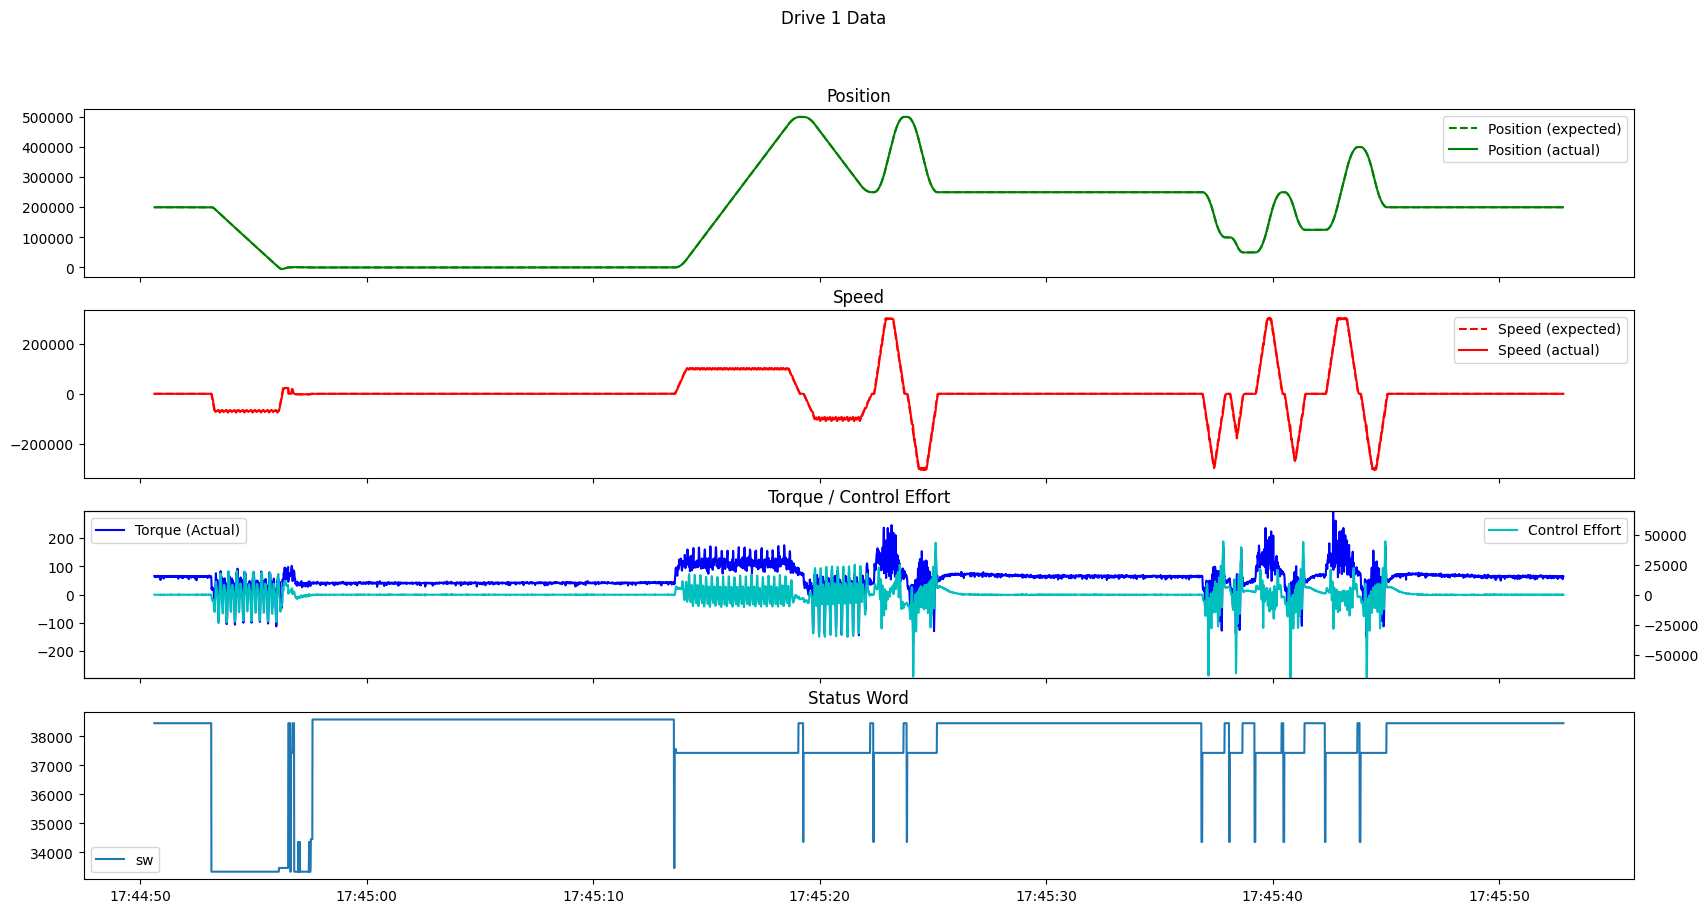

In [8]:
plot_drive(messages_unloaded, 1)

By looking at the graphs, we can see that both position and speed are as expected and the motor is behaving as intended.

Furthermore, we note the affine (proportional with offset) relationship between control effort and actual torque, indicating that the motor is able to correctly respond to control input.

#### 2.1.2 Drive 2

We plot the data for drive 2.

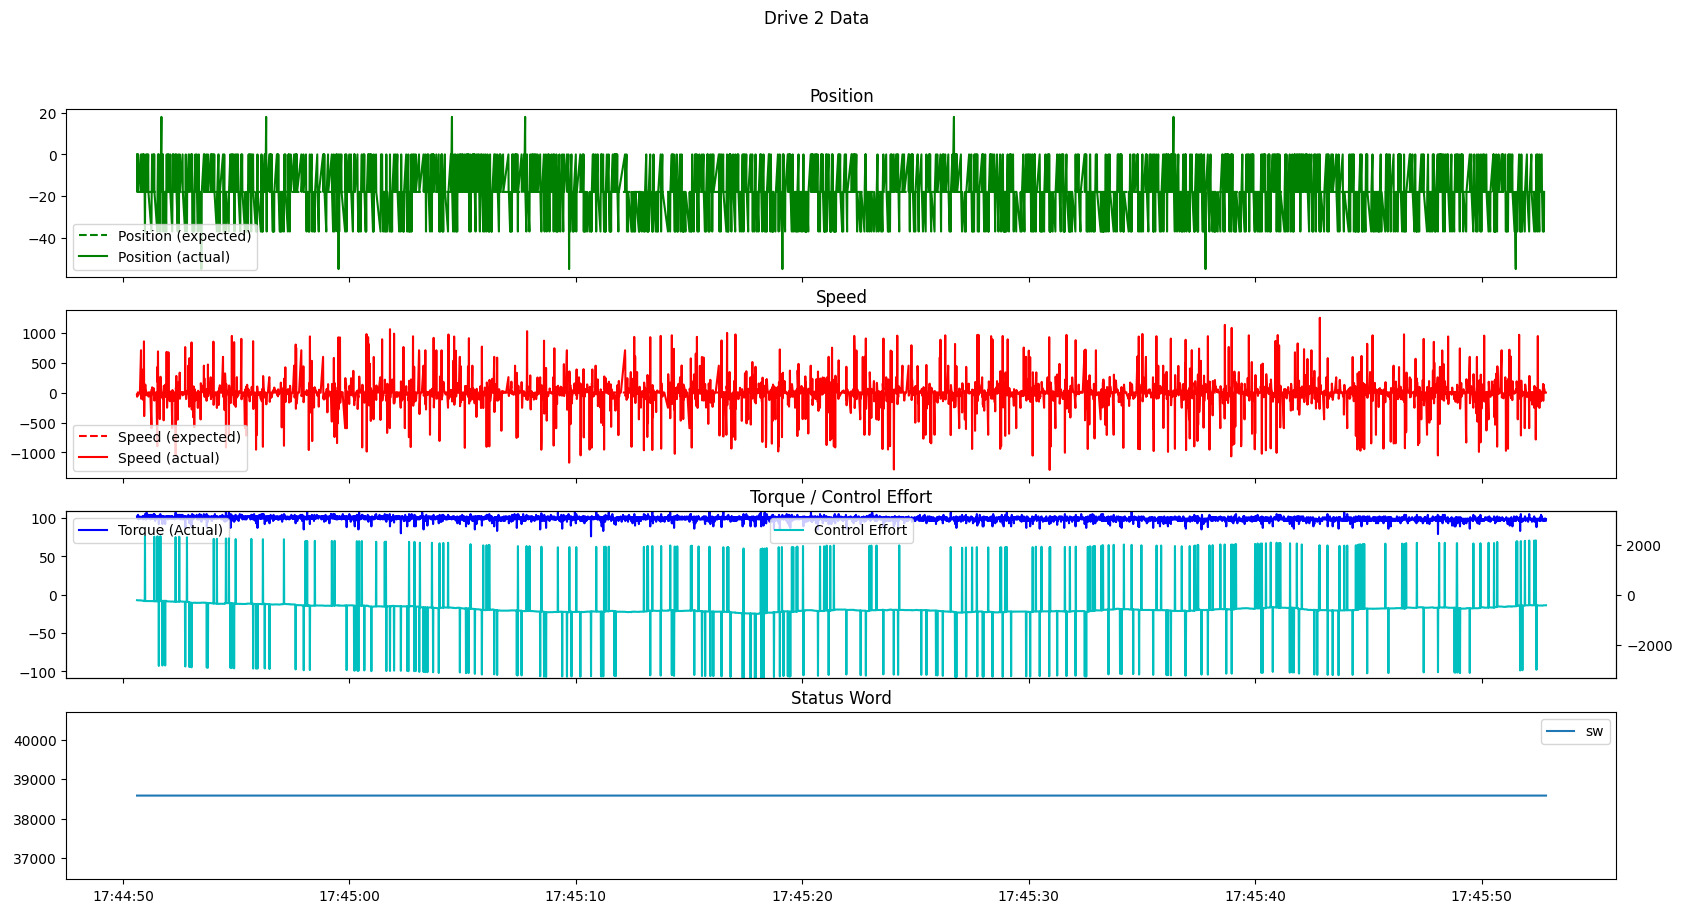

In [9]:
plot_drive(messages_unloaded, 2)

Given the graphs above we notice that changes in position, speed, and torque/control effort, are tiny.

It is therefore safe to assume that motor 2 is idle.

#### 2.1.3 Drive 3

We plot the data for drive 3.

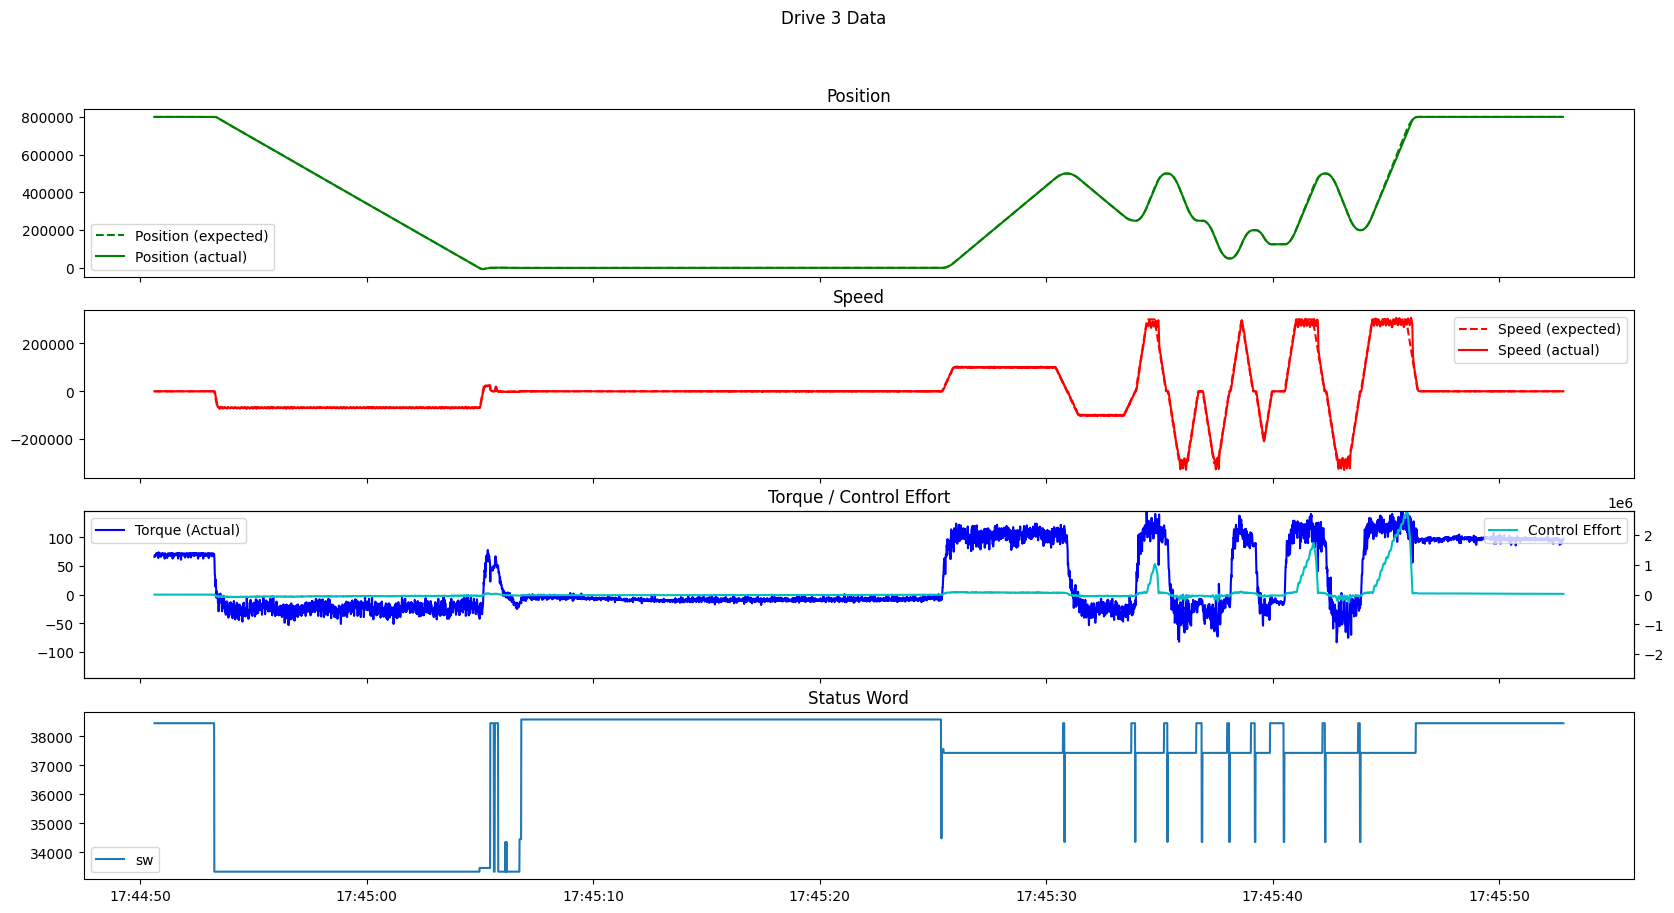

In [10]:
plot_drive(messages_unloaded, 3)

We can see that both position and speed are as expected and the motor is behaving as intended.

However, we notice a non-affine relationship between torque and control effort, where torque values plateau and saturate, indicating that the motor might be driven near its operational limits.

Furthermore, we notice that when idle:
- If the position is near 0, no control effort/torque is applied.
- If the position is high, the torque and control effort are constant.

This behavior suggests that motor 3 might be operating in the vertical plane. When idle at a non-zero position, it likely applies constant torque to counteract gravity, maintaining its position. Although this is a plausible explanation, it remains a hypothesis given the limited information available.

#### 2.1.4 Combined Moves: Drives 1 and 3

We code up a function to display the position graphs of both motors on top of each other, and adding dividers to indicate beginning and end of motions for either drive.

In [11]:
def plot_pos_comparison(messages: list[Message], drive1: int, drive2: int):
    """Plot two drives' position graphs and add motion start/end delimiters."""
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.suptitle("Driver Position Comparison")

    # Plot positions
    ax1.title.set_text(f"Driver {drive1} Position")
    plot_pos(ax1, messages[drive1][28])
    ax2.title.set_text(f"Driver {drive2} Position")
    plot_pos(ax2, messages[drive2][28])
    fig.set_size_inches((20, 10))

    # Add vertical bars at motion start/stop
    for i in range(1, len(messages[drive1][18])):
        if messages[drive1][18][i - 1].data[0] > messages[drive1][18][i].data[0] and messages[drive1][18][i].data[0] < 36000:
            ax1.axvline(x=messages[drive1][18][i].timestamp, color='gray')
            ax2.axvline(x=messages[drive1][18][i].timestamp, color='gray')
    for i in range(1, len(messages[drive2][18])):
        if messages[drive2][18][i - 1].data[0] > messages[drive2][18][i].data[0] and messages[drive2][18][i].data[0] < 36000:
            ax1.axvline(x=messages[drive2][18][i].timestamp, color='gray')
            ax2.axvline(x=messages[drive2][18][i].timestamp, color='gray')

    plt.legend()
    plt.show()

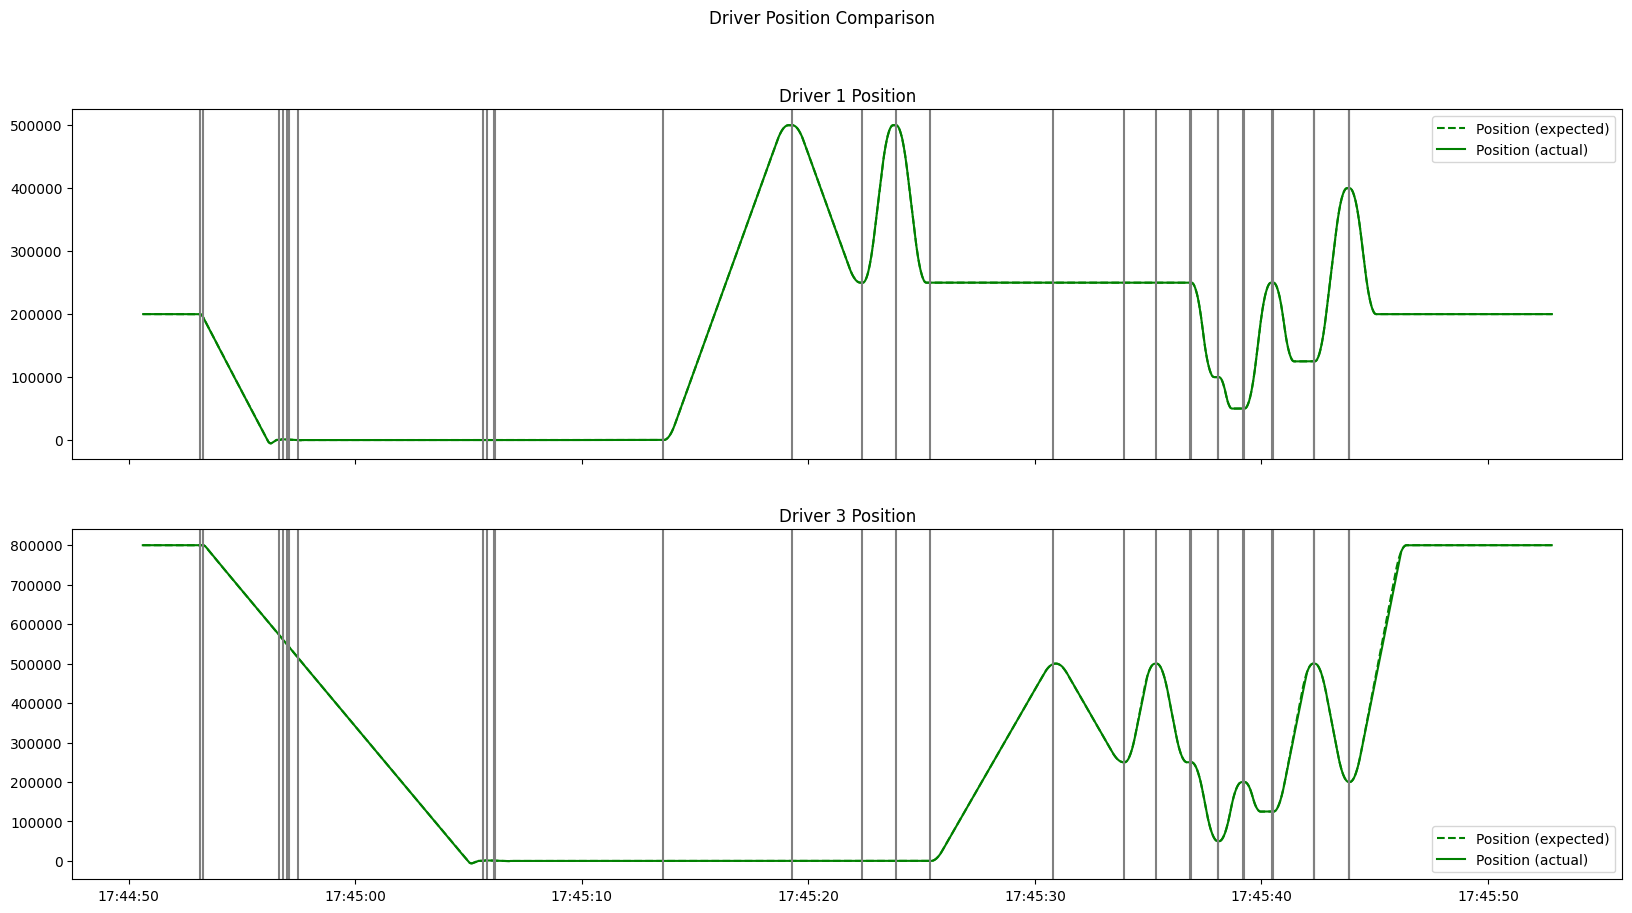

In [12]:
plot_pos_comparison(messages_unloaded, 1, 3)

We analyze the first three sections starting from the right.

- Section 1: Combined motion, position is as expected for whole duration, motions do not end at the same time.
- Section 2: Combined motion, position is as expected for whole duration, end at the same time (or almost).
- Section 3: Combined motion, position is as expected for whole duration, motions do not end at the same time.

As stated in the exercise, both motors in the combined motions should start and stop at the same time. But, given that in these three examples, the drives are behaving as expected at all times, we can conclude that there is a programmatic issue here as opposed to a mechanical failure, or torque insufficiency.

Indeed, it seems that the program executing these motions is not synchronizing combined motions. This is likely a functional issue in the code.

Given this, it also reasonable to assume that other combined motions appear to end at the same time, but do so uniquely by coincidence, as their displacement, and thus execution times, are similar.

#### 2.1.5. Motion Visualisation

As a bonus, the following piece of code generates an animation to show the actual vs. expected positions of both motors (motor 1 on x axis, motor 3 on y axis) through time.

Unfortunately, notebooks can't handle animations, so a version of it has been extraced to mp4 at `/out/unloaded.mp4`.

(I did not end up using this for any explanation so it has no real use).

In [13]:
def animate(vid_name: str, dr1: list[Message], dr2: list[Message]):
    # Extract x and y values for both lines
    expected_x = [m.data[0] for m in dr1]
    expected_y = [m.data[0] for m in dr2]

    actual_x = [m.data[1] for m in dr1]
    actual_y = [m.data[1] for m in dr2]

    # Set up the figure and axis
    fig, ax = plt.subplots()
    ax.set_xlim(min(min(expected_x), min(actual_x)), max(max(expected_x), max(actual_x)))
    ax.set_ylim(min(min(expected_y), min(actual_y)), max(max(expected_y), max(actual_y)))

    # Create line objects, which will be updated during the animation
    line1, = ax.plot([], [], lw=2, label='Expected')
    line2, = ax.plot([], [], lw=2, label='Actual')

    # Initialization function: plot the background of each frame
    def init():
        plt.title(dr1[0].timestamp.time())
        line1.set_data([], [])
        line2.set_data([], [])
        return line1, line2

    # Animation function: this is called sequentially
    def animate(i):
        # Update the lines with the new data up to index i
        plt.title(dr1[i].timestamp.time())
        line1.set_data(expected_x[max(0, i-30):i+1], expected_y[max(0, i-30):i+1])
        line2.set_data(actual_x[max(0, i-30):i+1], actual_y[max(0, i-30):i+1])
        return line1, line2

    # Call the animator
    anim = FuncAnimation(fig, animate, init_func=init, frames=len(expected_x), interval=10, blit=True)

    # Add a legend to distinguish the lines
    ax.legend()

    # Save the animation as a video file
    # Requires ffmpeg, if you have trouble running this, simply comment out and look at provided output in out/
    anim.save(vid_name, fps=60, extra_args=['-vcodec', 'libx264'])

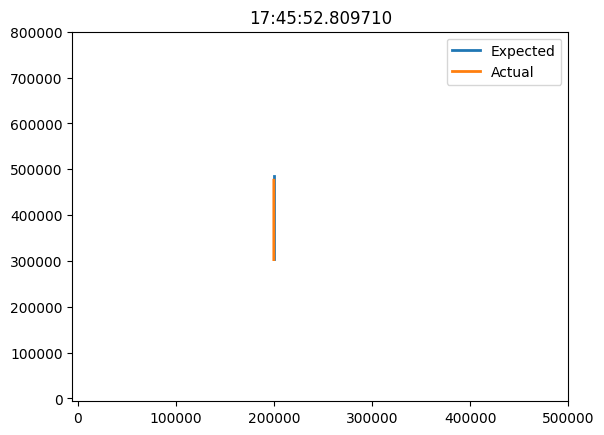

In [14]:
animate("./out/unloaded.mp4", messages_unloaded[1][28][:4192:2], messages_unloaded[3][28][:4192:2])

### 2.2. Loaded Analysis

We start by loading and parsing the log messages for the loaded run.

In [15]:
messages_loaded, nodes_loaded = load_logs("./logs/loaded.log")

We look at the generated node dictionary for insight on the information exhanged on the CAN bus.

In [16]:
print("Node | Channels")
print("-----|-----------------------------------------")
for key in sorted(nodes_loaded.keys()):
    print(f"{key}    | {sorted(nodes_loaded[key])}")

Node | Channels
-----|-----------------------------------------
0    | [0, 8]
1    | [8, 18, 20, 28, 30, 38, 48, 58, 60, 70]
2    | [18, 28, 38, 58, 60]
3    | [8, 18, 20, 28, 30, 38, 48, 58, 60, 70]
4    | [18, 58, 60]


As expected, the results are the same as for the unloaded run: nodes 1, 2, and 3 are motor drives.

#### 2.2.1. Drive 1

We plot our drive 1 data.

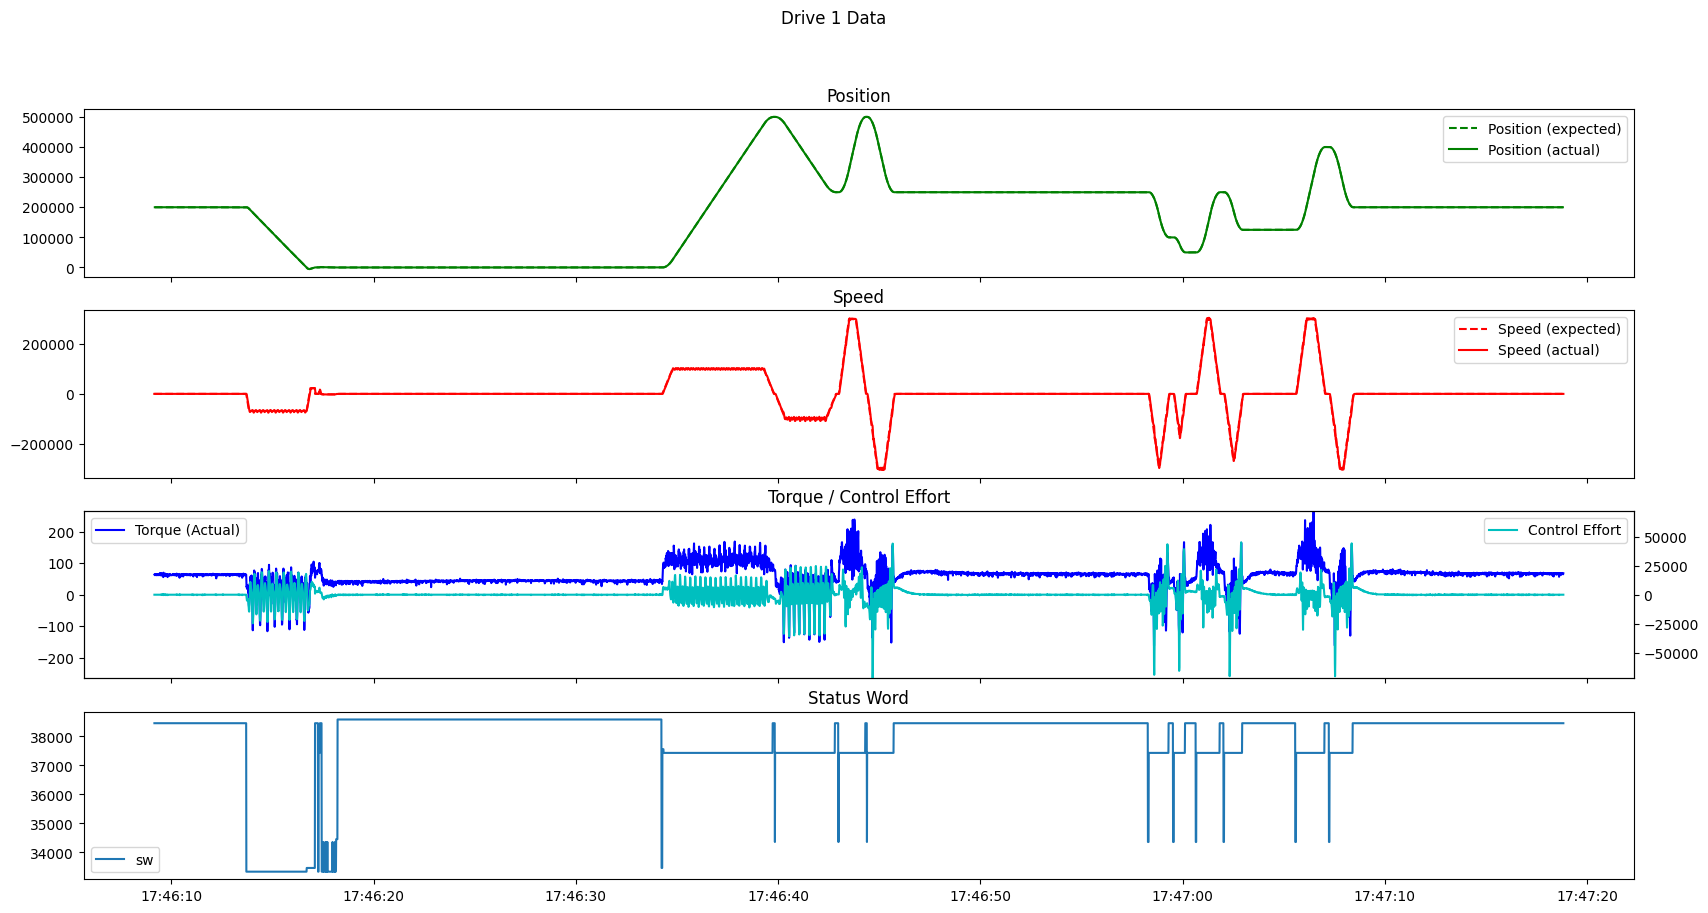

In [17]:
plot_drive(messages_loaded, 1)

Even under load, we can see that both position and speed are as expected and the motor is behaving as intended.

Again, we note the affine (proportional with offset) relationship between control effort and actual torque, indicating that the motor is able to correctly respond to control input.

#### 2.2.2 Drive 2

We plot our data for drive 2.

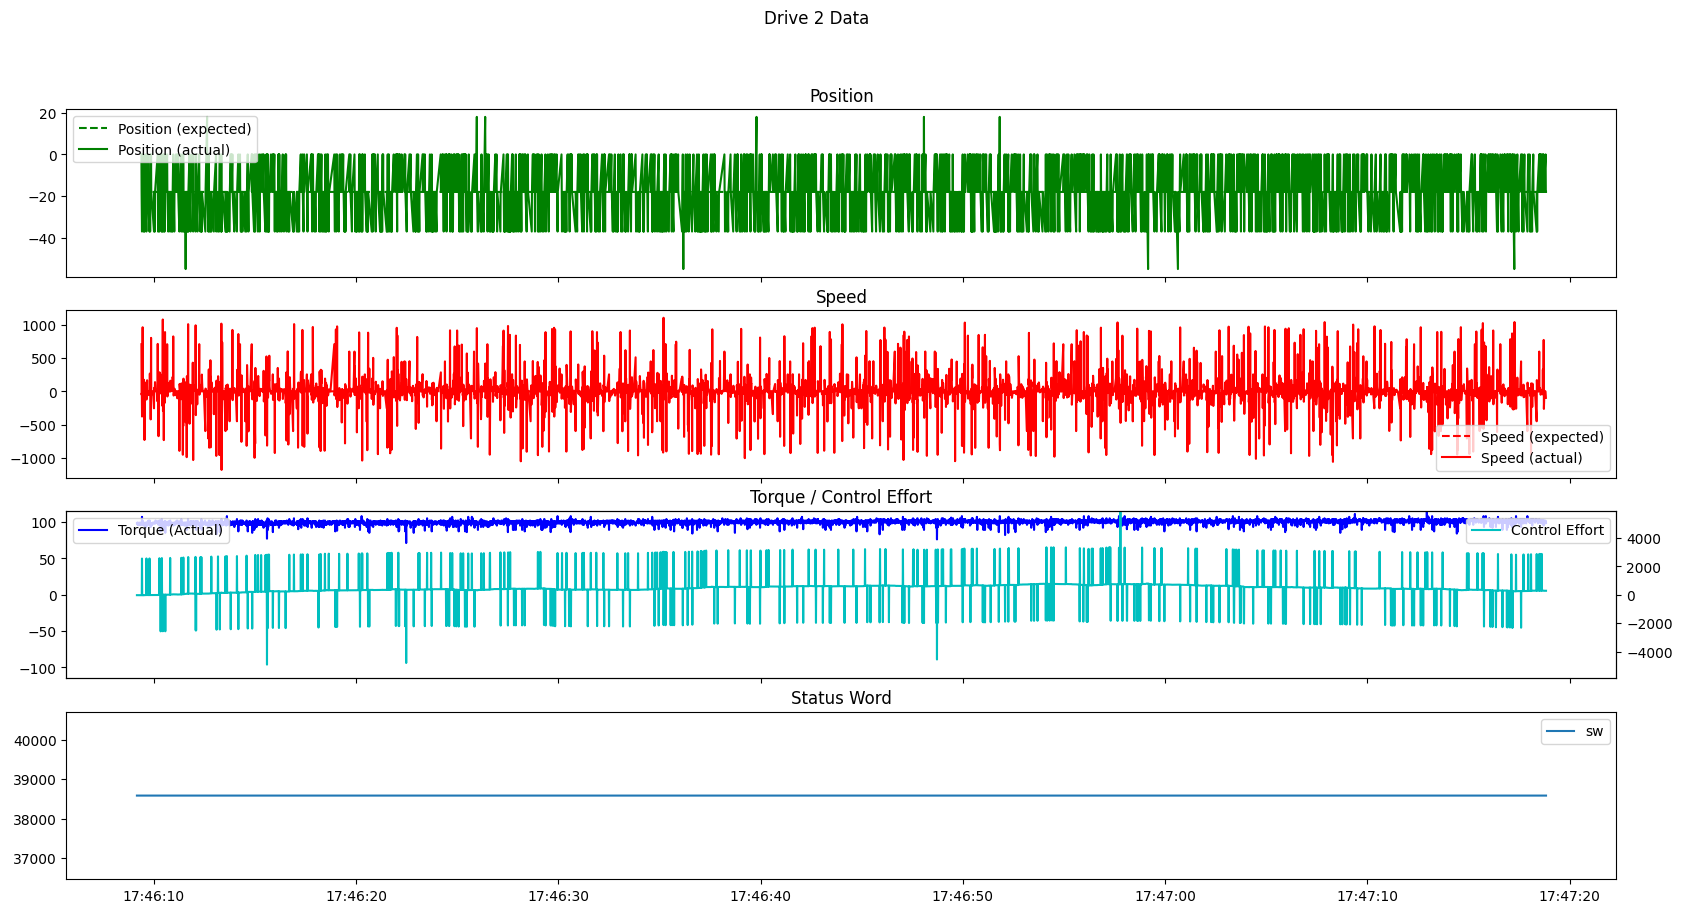

In [18]:
plot_drive(messages_loaded, 2)

As for the unloaded run, changes in position, speed, and torque/control effort, are tiny.

It is therefore safe to assume that motor 2 is idle.

#### 2.2.3 Drive 3

We plot our data for drive 3.

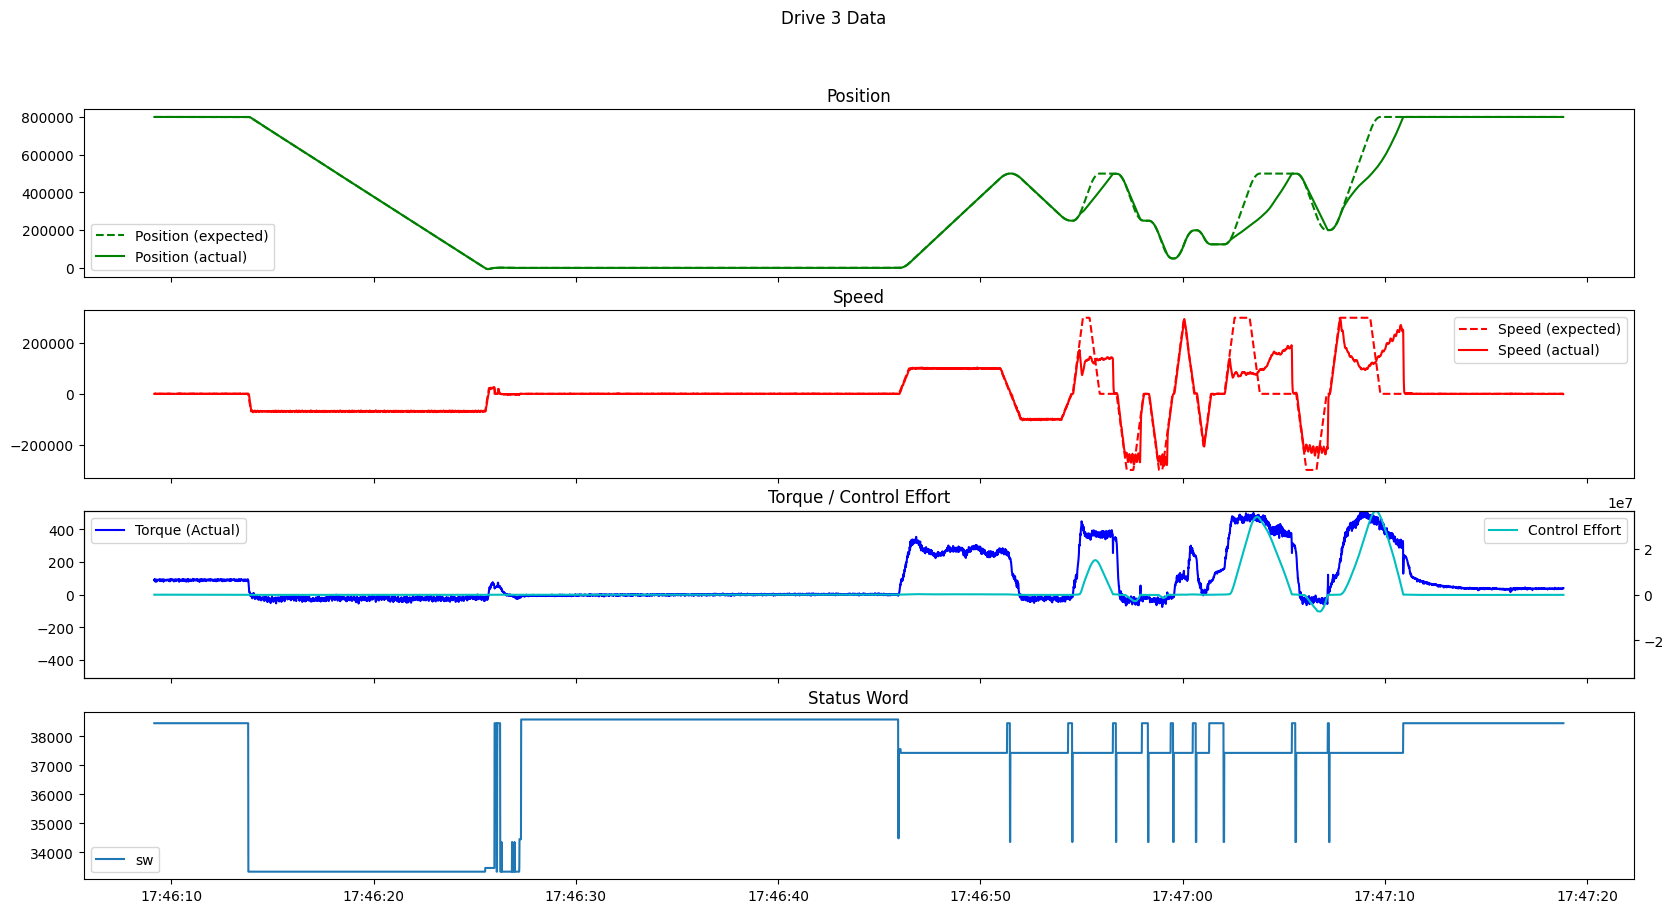

In [19]:
plot_drive(messages_loaded, 3)

This time, motor 3 is not working as intended.

When the position is rising, the speed of the motor can't keep up with the expected speed. Actual position therefore lags behind expected position.

Furthermore, we notice the same problem with torque as before, where torque values plateau and saturate instead of increasing with control effort, indicating that the motor has reached its operational limits.

This data is evidence for the fact that motor 3 is unable to handle the load that is placed on it. It's inability to keep up with positive speeds, and not negative speeds further reinforces the hypothesis that this motor operates on the vertical plane and is trying to lift a load that is too heavy for it.

#### 2.2.4. Combined Moves: Drives 1 and 3

We now plot both motor 1 and 3 positions to have a better look at combined motions.

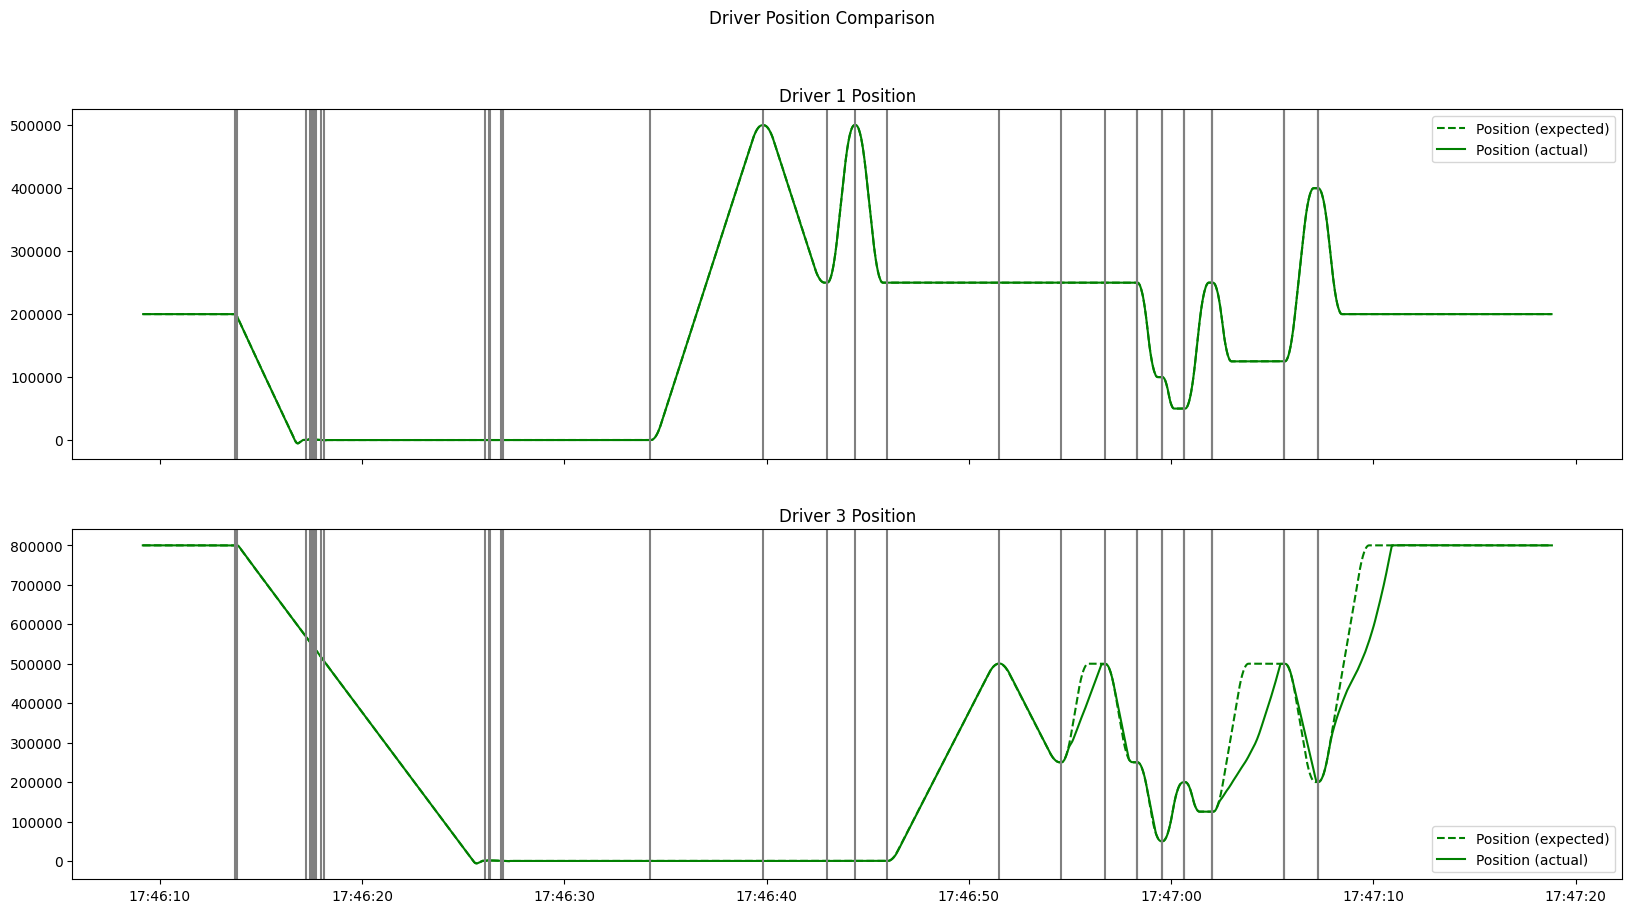

In [20]:
plot_pos_comparison(messages_loaded, 1, 3)

As before, we can see that combined motions do not end at the same time. By looking at section 3 (starting from the right), we can see that this effect is further exacerbated by the delayed response of motor 3. Indeed, motor 1 finishes its move and is then stalled by the slower than expected motion of motor 3.

These findings are consistent with the ones described by the customer.

#### 2.2.5. Motion Animation

Again, find the animation corresponding to the actual vs. expected position of both motors in `/out/loaded.mp4`.

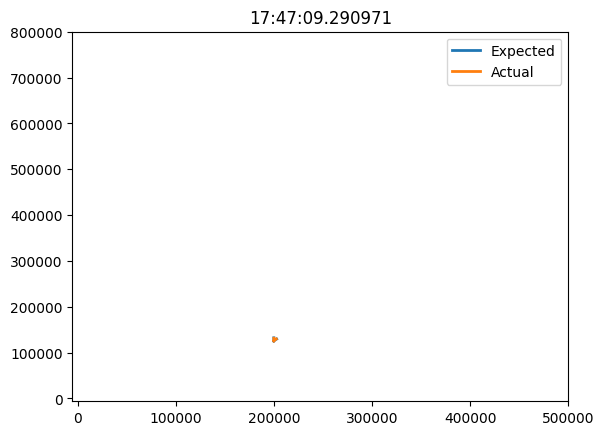

In [21]:
animate("./out/loaded.mp4", messages_loaded[1][28][:4192:2], messages_loaded[3][28][:4192:2])

## 3. Conclusion

After analysis, the log data revealed key insights about the behaviour of the motor drives under both loaded and unloaded conditions.

1. Unloaded run:
    - Both drives 1 and 3 exhibit motions that are going as expected.
    - The torque/control effort relationship in Drive 3 suggests operation near its mechanical limits, particularly when holding a non-zero position, likely indicating operation in a vertical plane.
    - Combined motions involving Drives 1 and 3 do not synchronize as intended, which is likely due to a programmatic issue rather than a mechanical fault or torque insufficiency.
2. Under load:
    - Under load, Motor 3 struggles to meet the expected motion profiles, indicating that it may not be powerful enough for the tasks it is assigned, particularly if it is indeed operating in a vertical plane.
    - This limitation causes delays in its movements, leading to extended stalling of Motor 1 during combined motions.


## 4. Recommendations

1. Fix the control program to ensure proper synchronization of combined motions.
2. Assess the mechanical load on Motor 3 to determine if it requires a more powerful motor or if its task can be reconfigured to reduce the load.

Further testing under varied conditions is recommended to validate these findings and refine the motion profiles.